The point of this exercise is implementing from scratch, which means only using Numpy, not even using a single feature of Scikit-learn, expect for loading the iris dataset.

In [119]:
import numpy as np

# Load the data

In [120]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

We need to add $x_0=1$ in the front of every instance. It would be easy to use add_dummy_feature, but we are here to defeat the black box.

In [121]:
X_with_bias = np.c_[np.ones(len(X)), X]

# Preprocessing the data

## Split the data

Of course, it would be very easy to use train_test_spilt in Scikit-learn, but we're not here for the easy stuff.

In [122]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(test_ratio * total_size)
valid_size = int(validation_ratio * total_size)
train_size = total_size - test_size - valid_size

np.random.seed(42)
index = np.random.permutation(len(X))

X_train: np.ndarray = X_with_bias[index[:train_size]]
y_train: np.ndarray = y[index[:train_size]]

X_valid: np.ndarray = X_with_bias[index[train_size:-test_size]]
y_valid: np.ndarray = y[index[train_size:-test_size]]

X_test: np.ndarray = X_with_bias[index[-test_size:]]
y_test: np.ndarray = y[index[-test_size:]]

- The target are currently indices (i.e. 0, 1 or 2), but we need class probabilities to use Softmax Regression. 
- Each instance will have a target vector contains 3 values, all the classes probabilities will be 0.0, expect for the target class, which will has the value is 1.0. In other words, this is an one-hot vector.
- This is a function from the author, using the properties of identity matrix.
- np.diag(np.one(n)) return an identity matrix of size n.
- Then we use [advanced Numpy indexing](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing), noting that if a is a numpy array, then a[[1, 2, 3]] return an array with 3 rows, each row equals to a[1], a[2]. a[3].

## Preprocessing the label

In [123]:
def to_one_hot(y):
    # This code create an 3x3 identity matrix, then apply numpy advanced indexing
    # After that, if the i-th row of y is a, then this code return the a-th row of the 3x3 identity matrix
    return np.diag(np.ones(y.max() + 1))[y]

In [124]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [125]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

It looks good, so let's apply it to create our target class probabilities matrix for the training, validation and test set.

In [126]:
y_train_one_hot = to_one_hot(y_train)
y_valid_one_hot = to_one_hot(y_valid)
y_test_one_hot = to_one_hot(y_test)

## Preprocessing the instances

Now, we will scale the instances using standard scaling, and once again, using only Numpy (I'm starting to miss Scikit-learn). <br>
Note that we don't want to include the bias term.

In [127]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

# Implement the algorithm

Now we need to implement softmax score, recall that softmax score is:
    $$\hat{p_k} = \sigma(s(x))_k=\frac{exp(s_k(x))}{\sum_{j=1}^k exp(s_j(x))}$$

In [128]:
def softmax(logits: list[np.ndarray]) -> np.ndarray:
    exponents: np.ndarray = np.exp(logits)
    exp_sums = exponents.sum(axis=1, keepdims=True)
    return exponents / exp_sums

Here we define the number of inputs and outputs.

In [129]:
n_inputs = X_train.shape[1]  # == 5 (4 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (the amount of iris classes)

- Now, we come to the trickiest part: Training!
- Theoretically, it's simple: We just need to translate the math equations into Python codes.
- But in practice, it is not easy.
- In particular, we can mix up the indices, or the order of the terms.
- You can even end up with code what is working (compiled), but is not actually computing the right things.
- A good way to ensure yu are correct is write down the shape of each tensor and evaluate the corresponding term of your equation is correct.
- You can also print the value out to evaluate them directly.

A reminder about the equations we need to write. <br>
The cost function:
    $$J(\Theta) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^Ky_k^{(i)}\ln(p_k^{(i)})$$
The gradient function:
    $$\nabla_{\theta_k}J(\Theta) = \frac{1}{m}\sum_{i=1}^{m}(p_k^{(i)}-y_k^{(i)})x^{(i)}$$
Note that $\ln(p_k^{(i)})$ may be not computable if $p_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to it, to ensure it is positive.

In [130]:
eta = 0.5
n_epochs = 5000
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_scores = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        cross_entropy = -(y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, cross_entropy.sum(axis=1).mean())
    errors = Y_scores - y_train_one_hot
    gradients = 1 / m * X_train.T @ errors
    Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.14519367480830644
2000 0.1301309575504088
3000 0.12009639326384539
4000 0.11372961364786884


And now we can inspect the model parameters.

In [131]:
Theta

array([[ 0.41925035,  6.11082848, -5.52394044],
       [-6.5302265 , -0.74577576,  8.33074179],
       [-5.28091134,  0.25137425,  6.90671025]])

Let's make prediction on the validation set and measure the accuracy.

In [132]:
Y_proba_valid: np.ndarray = softmax(X_valid @ Theta)
y_predict = Y_proba_valid.argmax(axis=1)

accuracy = (y_predict == y_valid).mean()
accuracy

0.9333333333333333

Because I have sniffed the solution notebook, let's add the $\ell_2$ norm to the cost function and the gradient vector as well.

In [133]:
eta = 0.5
n_epochs = 5000
m = len(X_train)
epsilon = 1e-5
alpha = 0.1  # regularization hyperparameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_scores = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        cross_entropy = -(y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = (
            0.5 * (Theta[1:] ** 2).sum()
        )  # we don't count the bias term, so we ignore the first row
        print(epoch, cross_entropy.sum(axis=1).mean() + alpha * l2_loss)
    errors = Y_scores - y_train_one_hot
    gradients = 1 / m * X_train.T @ errors
    gradients += np.r_[np.zeros((1, n_outputs)), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.9952080106594807
1000 0.6075582807173319
2000 0.6075582807173319
3000 0.6075582807173319
4000 0.6075582807173319


Using $\ell_2$, it looks like the validation is better, but does the model improve?

In [134]:
Y_proba_valid: np.ndarray = softmax(X_valid @ Theta)
y_predict = Y_proba_valid.argmax(axis=1)

accuracy = (y_predict == y_valid).mean()
accuracy

0.9333333333333333

Well, it looks like it does not improve. Maybe change the alpha?

Finally, the part we are waiting for: Early stopping! For this, we need to measure the validation cost function and stop when the cost stop decreasing.

In [135]:
eta = 0.5
n_epochs = 50000
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.inf

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_scores = softmax(logits)

    Y_proba_valid = softmax(X_valid @ Theta)
    cross_entropy = -(y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = cross_entropy.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss)
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss)
        print(epoch, total_loss)
        print("Early Stopping!")
        break
    errors = Y_scores - y_train_one_hot
    gradients = 1 / m * X_train.T @ errors
    gradients += np.r_[np.zeros((1, n_outputs)), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372435648488707
281 0.32564059682266994
282 0.32564059811647006
Early Stopping!


In [136]:
Y_proba_valid: np.ndarray = softmax(X_valid @ Theta)
y_predict = Y_proba_valid.argmax(axis=1)

accuracy = (y_predict == y_valid).mean()
accuracy

0.9333333333333333

Not much change, but we shortened training time quite a bit.

Now, we will plot the prediction on the whole dataset.

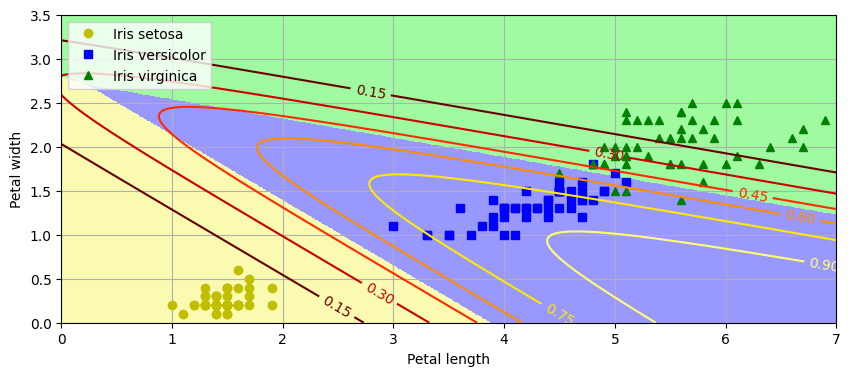

In [137]:
import matplotlib as mpl
import matplotlib.pyplot as plt

custom_cmap = mpl.colors.ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(
    np.linspace(0, 7, 800).reshape(-1, 1), np.linspace(0, 3.5, 400).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba: np.ndarray = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.legend(loc="upper left")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

In [138]:
Theta

array([[ 0.21881816,  1.99502866, -1.20770843],
       [-2.1751076 ,  0.49822019,  1.93348584],
       [-1.82855743, -0.27431567,  2.55955427]])

In [139]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667

- We even have better performance on the test set. 
- This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. 
- Try changing the random seed and running the code again a few times, you will see that the results will vary.